In [67]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [68]:
CaseName_Base = 'RTS24_mod1'
CaseName_ByStages = CaseName_Base + '_ByStages_nc'

Folder_A = 'A.The_full_year_MILP'
Folder_B = 'B.Operation_cost'
Folder_D = 'D.Representative_days_based_on_RES_and_Demand'
Folder_E = 'E.Representative_days_based_on_Line_Benefits_OptModel'
Folder_F = 'F.Representative_days_based_on_Line_Benefit_NN_OC_fy_1'
Folder_G = 'G.Representative_days_based_on_Line_Benefit_NN_OC_fy_2'
Folder_K = 'K.Investments_per_hour'
Folder_L = 'L.Cont_Investments_per_hour'

Folder_JB = 'J.Full_year_operational_cost\\Results\\B.'
Folder_JD = 'J.Full_year_operational_cost\\Results\\D.'
Folder_JE = 'J.Full_year_operational_cost\\Results\\E.'
Folder_JF = 'J.Full_year_operational_cost\\Results\\F.'
Folder_JG = 'J.Full_year_operational_cost\\Results\\G.'
Folder_JK = 'J.Full_year_operational_cost\\Results\\K.'
Folder_JL = 'J.Full_year_operational_cost\\Results\\L.'

DirName  = os.getcwd()
_path_0 = os.path.join(DirName, CaseName_Base)
category_dict = {Folder_A: "FYMILP",
                 Folder_B: "OPC",
                 Folder_D: "R&D",
                 Folder_E: "OPT_LB",
                 Folder_F: "NN_LB1",
                 Folder_G: "NN_LB2",
                 Folder_K: "Hourly_inv",
                 Folder_L: "CHI",
                 Folder_JB: "OPC_fy",
                 Folder_JD: "R&D_fy",
                 Folder_JE: "OPT_LB_fy",
                 Folder_JF: "NN_LB_fy1",
                 Folder_JG: "NN_LB_fy2",
                 Folder_JK: "HI_fy",
                 Folder_JL: "CHI_fy"
                }

In [69]:
def LoadingData(dir, folder,result, case, ncluster, cm):
    if folder == 'A.The_full_year_MILP': 
        df = pd.read_csv(os.path.join(dir, folder, case, '3.Out', f'oT_Result_{result}_'+case+'.csv'), index_col=[0,1])
    else: 
        df = pd.read_csv(os.path.join(dir, folder, case+'_ByStages_nc'+str(ncluster), '3.Out', f'oT_Result_{result}_'+case+ '_ByStages_nc'+str(ncluster)+'.csv'), index_col=[0,1])

    df['CaseName'] = folder + ' - ' + case + str(ncluster)
    df['Clustering method'] = cm
#     df['Category2'] = cat2
#     df['Category3'] = cat3
    df['Number of clusters'] = ncluster
    df = df.reset_index()
#df = df.reset_index().set_index(['CaseName', 'Category1', 'Category2', 'Category3', 'Category4'])
    # df = df.set_index('CaseName', append=True)
    return df
def LoadingWeights(dir, folder, case, ncluster):
    if folder == 'A.The_full_year_MILP': 
        df_stage = pd.read_csv(os.path.join(dir, folder, case, '2.Par', f'oT_Data_Stage_'+case+'.csv'))
        df_duration = pd.read_csv(os.path.join(dir, folder, case, '2.Par', f'oT_Data_Duration_'+case+'.csv'))
    else: 
        df_stage = pd.read_csv(os.path.join(dir, folder, case+'_ByStages_nc'+str(ncluster), '2.Par', f'oT_Data_Stage_'+case+ '_ByStages_nc'+str(ncluster)+'.csv'))
        df_duration = pd.read_csv(os.path.join(dir, folder, case+'_ByStages_nc'+str(ncluster), '2.Par', f'oT_Data_Duration_'+case+ '_ByStages_nc'+str(ncluster)+'.csv'))
    durations_filtered = df_duration[df_duration['Duration'] == 1]
    merged_df = pd.merge(df_stage, durations_filtered, left_on='Unnamed: 0', right_on='Stage', how='left')

    return merged_df
def get_overall_avg_utilization(df_utilization): 
    return df_utilization["GWh"].mean()
def get_weighted_overall_avg_Utilization(df_util,df_weights):
    merged_df = df_util.merge(df_weights,how = "left",on = "LoadLevel")
    merged_df["GWh_weighted"] = merged_df["GWh"] * merged_df["Weight"]
    return merged_df["GWh_weighted"].sum()/merged_df["Weight"].sum()

In [70]:
nbs_clusters = [(i+1)*10 for i in range(10)] + [150, 200, 250, 300,350, 400]

folders = [Folder_JB, Folder_JD,Folder_JE,Folder_JL]#,Folder_E,Folder_F,Folder_G]
folders = [Folder_A,Folder_B,Folder_D,Folder_E,Folder_L]
folders = [Folder_A,Folder_L,Folder_JL,Folder_D,Folder_JD,Folder_B,Folder_JB,Folder_E,Folder_JE]
results = ["NetworkUtilizationPerNode_DC"]

results_dfs = dict()
weights_dfs = dict()
for result in results :
    results_dfs[result] = dict()
    weights_dfs[result] = dict()
    for folder in folders: 
        results_dfs[result][folder] = dict()
        weights_dfs[result][folder] = dict()
        for nb_clusters in nbs_clusters:
            try: 
                results_dfs[result][folder][nb_clusters] = LoadingData(DirName, folder,result, CaseName_Base, nb_clusters, category_dict[folder])
                if not(folder.startswith("J")):
                    weights_dfs[result][folder][nb_clusters] = LoadingWeights(DirName,folder,CaseName_Base,nb_clusters)
            except FileNotFoundError as e : 
                print(e)
                print(folder,nb_clusters, "Does not contain", result)

In [71]:
df_util = results_dfs[result]["D.Representative_days_based_on_RES_and_Demand"][10]
df_weights = weights_dfs[result]["D.Representative_days_based_on_RES_and_Demand"][10]
merged_df = df_util.merge(df_weights,how = "left",on = "LoadLevel")
merged_df["GWh_weighted"] = merged_df["GWh"] * merged_df["Weight"]
merged_df["GWh_weighted"].sum()/merged_df["Weight"].sum()

0.17314218955691224

In [72]:
result = "NetworkUtilizationPerNode_DC"
overal_avg_utilization = pd.DataFrame()
all_utils =pd.DataFrame()
i=0
for folder in folders:
    print(folder)
    for nb_clusters in nbs_clusters: 
#         print(nb_clusters)
        overall_avg_util = get_overall_avg_utilization(results_dfs[result][folder][nb_clusters])
        if folder.startswith("J."): 
            overall_weighted_utilization = overall_avg_util
        else:
            overall_weighted_utilization = get_weighted_overall_avg_Utilization(results_dfs[result][folder][nb_clusters],weights_dfs[result][folder][nb_clusters])
        row = pd.DataFrame({"Clustering method":category_dict[folder] ,"Number of clusters": nb_clusters,"Avg_util":overall_avg_util,"Avg_util_w":overall_weighted_utilization} ,index = [i])
        i+=1
        overal_avg_utilization = pd.concat([overal_avg_utilization,row])
        all_utils = pd.concat([all_utils,results_dfs[result][folder][nb_clusters]])

        
overal_avg_utilization.set_index("Clustering method",inplace=True)

A.The_full_year_MILP
L.Cont_Investments_per_hour
J.Full_year_operational_cost\Results\L.
D.Representative_days_based_on_RES_and_Demand
J.Full_year_operational_cost\Results\D.
B.Operation_cost
J.Full_year_operational_cost\Results\B.
E.Representative_days_based_on_Line_Benefits_OptModel
J.Full_year_operational_cost\Results\E.


In [73]:
overal_avg_utilization.loc["OPC"]

,Number of clusters,Avg_util,Avg_util_w
Clustering method,,,
OPC,10,0.141919,0.141566
OPC,20,0.164290,0.140622
OPC,30,0.108303,0.104984
OPC,40,0.135589,0.115604
OPC,50,0.150892,0.139452
OPC,60,0.140922,0.127889
OPC,70,0.144297,0.128083
OPC,80,0.151886,0.136741
OPC,90,0.154689,0.136497


In [74]:
selected_nbs = [10,20,30]
selected_cms = ["FYMILP","R&D_fy","CHI_fy","OPT_LB_fy"]
selected_cms = ["FYMILP","R&D","CHI","OPT_LB"]
filter_ = all_utils["Number of clusters"].isin(selected_nbs) &  all_utils["Clustering method"].isin(selected_cms)

<Axes: xlabel='Number of clusters', ylabel='GWh'>

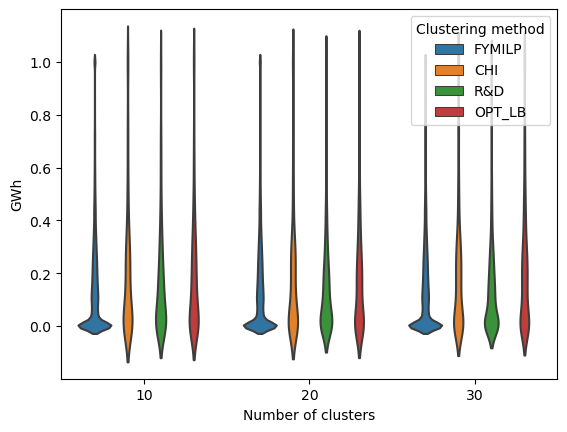

In [75]:
all_utils_sel = all_utils[filter_]
sns.violinplot(data = all_utils_sel,x = "Number of clusters",y = "GWh",hue = "Clustering method",inner=None)

<Axes: xlabel='Number of clusters', ylabel='GWh'>

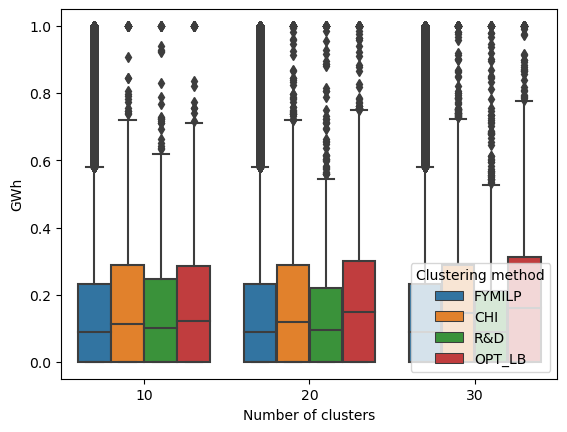

In [76]:
sns.boxplot(data = all_utils_sel,x = "Number of clusters",y = "GWh",hue = "Clustering method")

<Axes: xlabel='Number of clusters', ylabel='Avg_util'>

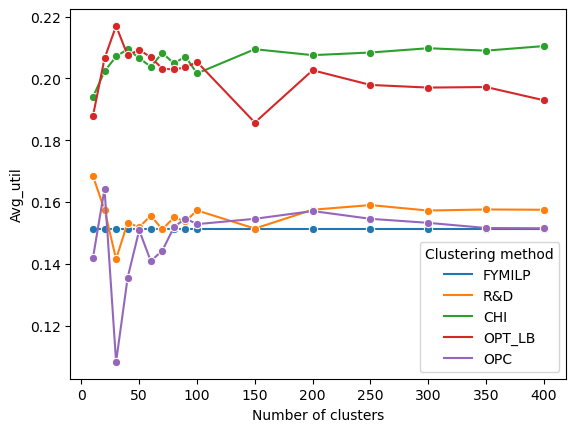

In [78]:
#Regular line plots
y = "Avg_util"
x = "Number of clusters"
rf = overal_avg_utilization.loc[["FYMILP","R&D_fy","CHI_fy","OPT_LB_fy","OPC_fy"]]
rf = overal_avg_utilization.loc[["FYMILP","R&D","CHI","OPT_LB","OPC"]]
#rf = agg_results
sns.lineplot(data = rf,x = x, y = y,hue = "Clustering method",marker = "o")